### MACS 207 b | Projet 2 | Hugo QUENIAT et Aristide LALOUX

### Hawkes Processes

In this project we consider cyber security attacks arriving at different time. In a CSV file, we have all the logs. After retrieving and sorting the attacks, we would like to find a model to determine the time arrivals of the attacks. We will try to modelize this by a Hawkes Process.

Let's first store in a list the arrival times of the attacks.

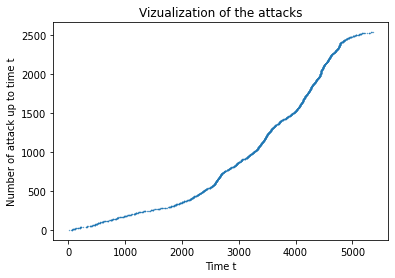

In [12]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
import numpy as np
import matplotlib.pylab as plt
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
plt.scatter(l,1+np.arange(len(l)),s=0.1)
plt.xlabel("Time t")
plt.ylabel("Number of attack up to time t")
plt.title("Vizualization of the attacks")
plt.show()

We modelize the arrival of the hacking attacks by a point process N. We denote $T_n$ the arrival of the attacks. We modelize it as a Hawkes Process. The intensity is therefore of the following form:

$\dot{y}(N,t) = \alpha + \beta \int_0^{t^-} e^{-\gamma(t-s)}dN(s) = \alpha + \beta \sum_{T_n<t} e^{-\gamma(t-T_n)}$

With : $\alpha, \beta, \gamma$ positive real numbers and such that $\beta < \gamma$

Thanks to our reasoning in the exercise 3.4.2, we know that the log-likelihood is given by :

$log(L(N,t)) = \sum_{T_n\leq t} log\left(\alpha + \beta \sum_{j=1}^{n-1} e^{- \gamma(T_n-T_j) } \right) + (1-\alpha)t - \frac{\beta}{\gamma}\sum_{T_n\leq t} \left( 1- e^{-\gamma (t-T_n)}\right)$

The goal is to first maximize the log-likelihood function. We choose to maximize the function for $t=max_n(T_n)$ because we want to fit our model to as much information as possible.

To make computations faster we compute only one time the list of all the $(T_n-T_j)$

In [13]:
T_list = l
T_diff = []

for n in range(len(T_list)):
    sublist = []
    for j in range(n):
        sublist.append(T_list[n] - T_list[j])

    T_diff.append(sublist)

Then we compute the function -$log(L(\alpha, \beta, \gamma))$ to minimize. We also compute the constraints

In [14]:
def NegativeLogL(parameters, Dontprint=True):
  
  alpha, beta, gamma = parameters
  
  t=max(l)
  logL = np.log(alpha) + (1-alpha)*t  - (beta/gamma) ##La somme est vide pour n=0

  for n in range(1, len(T_list)): 
  
    inner_sum = np.sum(np.exp(-gamma * np.array(T_diff[n])))
    logL = logL + np.log(alpha + beta*inner_sum) - (beta/gamma)* (1 - np.exp(-gamma*(t-T_list[n])))
    
  if Dontprint == False :
    print("alpha = " + str(alpha) + " | beta = " + str(beta) + " | gamma = "+ str(gamma))
    print("VALUE = " + str(-logL))
    print(" ")
  return (-logL)

def constraint_function(parameters):

  alpha, beta, gamma = parameters
  
  return(beta - gamma) # beta - gamma < 0

Since we don't know the general shape of -$log(L(\alpha,\beta,\gamma))$ before using a minimizing algorithm from scipy, we first plot in 1D the function. It will give us the general shape of it.




- #### Parameter $\alpha$ :

`(Takes about 1min10s to compute)`

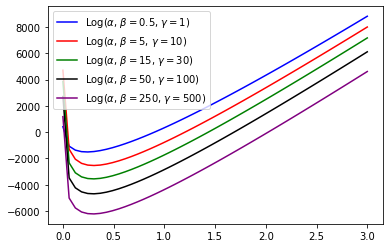

Best alpha Blue =  0.24581632653061225
Best alpha Red =  0.3070204081632653
Best alpha Green =  0.3070204081632653
Best alpha Black =  0.3070204081632653
Best alpha Purple =  0.3070204081632653


In [47]:
alphas = np.linspace(0.001,3)

y_alpha1 = [[NegativeLogL([alpha,0.5,1])] for alpha in alphas]
y_alpha2 = [[NegativeLogL([alpha,5,10])] for alpha in alphas]
y_alpha3 = [[NegativeLogL([alpha,15,30])] for alpha in alphas]
y_alpha4 = [[NegativeLogL([alpha,50,100])] for alpha in alphas]
y_alpha5 = [[NegativeLogL([alpha,250,500])] for alpha in alphas]

plt.plot(alphas, y_alpha1, label=r"Log($\alpha$, $\beta=0.5$, $\gamma=1$)", color="blue")
plt.plot(alphas, y_alpha2, label=r"Log($\alpha$, $\beta=5$, $\gamma=10$)", color="red")
plt.plot(alphas, y_alpha3, label=r"Log($\alpha$, $\beta=15$, $\gamma=30$)", color="green")
plt.plot(alphas, y_alpha4, label=r"Log($\alpha$, $\beta=50$, $\gamma=100$)", color="black")
plt.plot(alphas, y_alpha5, label=r"Log($\alpha$, $\beta=250$, $\gamma=500$)", color="purple")

plt.legend()
plt.show()

print("Best alpha Blue = ",alphas[np.argmin(y_alpha1)])
print("Best alpha Red = ",alphas[np.argmin(y_alpha2)])
print("Best alpha Green = ",alphas[np.argmin(y_alpha3)])
print("Best alpha Black = ",alphas[np.argmin(y_alpha4)])
print("Best alpha Purple = ",alphas[np.argmin(y_alpha5)])


As we can see, when $\beta$ and $\gamma$ are fixed, it seems that the best $\alpha$ to minimize the function is around $0.307$

We will use this value to plot -$log(L(\alpha,\beta,\gamma))$ in function of $\beta$ and then $\gamma$.

- #### Parameter $\beta$ :

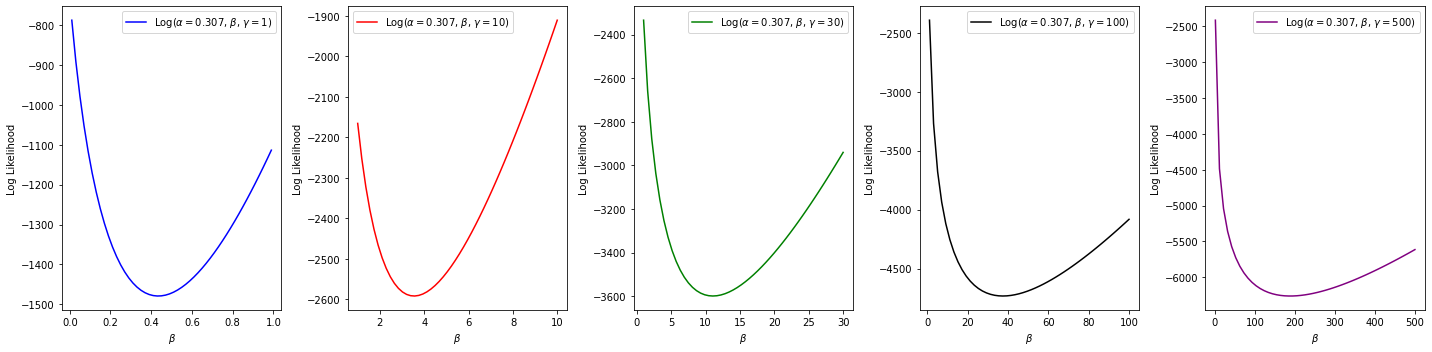

Best Beta Blue =  0.43
Best Beta Red =  3.5685714285714285
Best Beta Green =  11.057755102040817
Best Beta Black =  37.36367346938775
Best Beta Purple =  184.30244897959182


In [54]:
betas1 = np.linspace(0.01,0.99)
betas2 = np.linspace(1,9.99)
betas3 = np.linspace(1,29.99)
betas4 = np.linspace(1,99.99)
betas5 = np.linspace(1,499.99)

y_beta1 = [[NegativeLogL([0.307,beta,1])] for beta in betas1]
y_beta2 = [[NegativeLogL([0.307,beta,10])] for beta in betas2]
y_beta3 = [[NegativeLogL([0.307,beta,30])] for beta in betas3]
y_beta4 = [[NegativeLogL([0.307,beta,100])] for beta in betas4]
y_beta5 = [[NegativeLogL([0.307,beta,500])] for beta in betas5]

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].plot(betas1, y_beta1, label=r"Log($\alpha=0.307$, $\beta$, $\gamma=1$)", color="blue")
axes[0].set_xlabel(r"$\beta$")
axes[0].set_ylabel("Log Likelihood")
axes[0].legend()

axes[1].plot(betas2, y_beta2, label=r"Log($\alpha=0.307$, $\beta$, $\gamma=10$)", color="red")
axes[1].set_xlabel(r"$\beta$")
axes[1].set_ylabel("Log Likelihood")
axes[1].legend()

axes[2].plot(betas3, y_beta3, label=r"Log($\alpha=0.307$, $\beta$, $\gamma=30$)", color="green")
axes[2].set_xlabel(r"$\beta$")
axes[2].set_ylabel("Log Likelihood")
axes[2].legend()

axes[3].plot(betas4, y_beta4, label=r"Log($\alpha=0.307$, $\beta$, $\gamma=100$)", color="black")
axes[3].set_xlabel(r"$\beta$")
axes[3].set_ylabel("Log Likelihood")
axes[3].legend()

axes[4].plot(betas5, y_beta5, label=r"Log($\alpha=0.307$, $\beta$, $\gamma=500$)", color="purple")
axes[4].set_xlabel(r"$\beta$")
axes[4].set_ylabel("Log Likelihood")
axes[4].legend()

plt.tight_layout()
plt.show()

print("Best Beta Blue = ",betas1[np.argmin(y_beta1)])
print("Best Beta Red = ",betas2[np.argmin(y_beta2)])
print("Best Beta Green = ",betas3[np.argmin(y_beta3)])
print("Best Beta Black = ",betas4[np.argmin(y_beta4)])
print("Best Beta Purple = ",betas5[np.argmin(y_beta5)])
 

As we can see, when we fix $\alpha$ and $\gamma$ there is also a minimum for $\beta$. However it seems that the best $\beta$ inscreases with $\gamma$

- #### Parameter $\gamma$ :

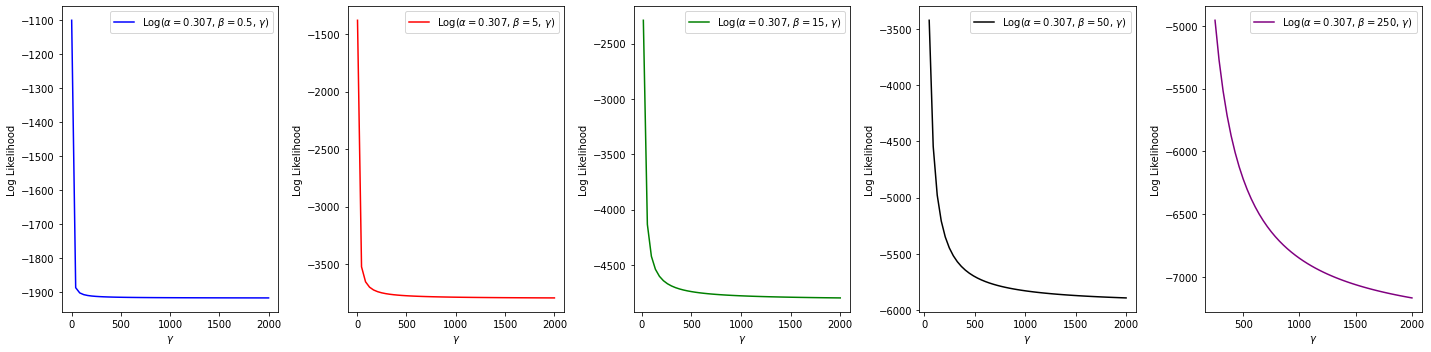

Best Gamma Blue =  2000.0
Best Gamma Red =  2000.0
Best Gamma Green =  2000.0
Best Gamma Black =  2000.0
Best Gamma Purple =  2000.0


In [57]:
gammas1 = np.linspace(0.501,2000)
gammas2 = np.linspace(5.01,2000)
gammas3 = np.linspace(15.01,2000)
gammas4 = np.linspace(50.01,2000)
gammas5 = np.linspace(250.01,2000)

y_gamma1 = [[NegativeLogL([0.307,0.5,gamma])] for gamma in gammas1]
y_gamma2 = [[NegativeLogL([0.307,5,gamma])] for gamma in gammas2]
y_gamma3 = [[NegativeLogL([0.307,15,gamma])] for gamma in gammas3]
y_gamma4 = [[NegativeLogL([0.307,50,gamma])] for gamma in gammas4]
y_gamma5 = [[NegativeLogL([0.307,250,gamma])] for gamma in gammas5]

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].plot(gammas1, y_gamma1, label=r"Log($\alpha=0.307$, $\beta=0.5$, $\gamma$)", color="blue")
axes[0].set_xlabel(r"$\gamma$")
axes[0].set_ylabel("Log Likelihood")
axes[0].legend()

axes[1].plot(gammas2, y_gamma2, label=r"Log($\alpha=0.307$, $\beta=5$, $\gamma$)", color="red")
axes[1].set_xlabel(r"$\gamma$")
axes[1].set_ylabel("Log Likelihood")
axes[1].legend()

axes[2].plot(gammas3, y_gamma3, label=r"Log($\alpha=0.307$, $\beta=15$, $\gamma$)", color="green")
axes[2].set_xlabel(r"$\gamma$")
axes[2].set_ylabel("Log Likelihood")
axes[2].legend()

axes[3].plot(gammas4, y_gamma4, label=r"Log($\alpha=0.307$, $\beta=50$, $\gamma$)", color="black")
axes[3].set_xlabel(r"$\gamma$")
axes[3].set_ylabel("Log Likelihood")
axes[3].legend()

axes[4].plot(gammas5, y_gamma5, label=r"Log($\alpha=0.307$, $\beta=250$, $\gamma$)", color="purple")
axes[4].set_xlabel(r"$\gamma$")
axes[4].set_ylabel("Log Likelihood")
axes[4].legend()

plt.tight_layout()
plt.show()

print("Best Gamma Blue = ",gammas1[np.argmin(y_gamma1)])
print("Best Gamma Red = ",gammas2[np.argmin(y_gamma2)])
print("Best Gamma Green = ",gammas3[np.argmin(y_gamma3)])
print("Best Gamma Black = ",gammas4[np.argmin(y_gamma4)])
print("Best Gamma Purple = ",gammas5[np.argmin(y_gamma5)])
 

As we can see, it seems that when we fix $\alpha$ and $\beta$, the minimum of $-LogL(\gamma)$ is located at $\gamma \rightarrow +\infty$

We can see it better by computing $LogL(\beta,\gamma)$ in 3D.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

betas3D = np.linspace(0.1, 10)  
gammas3D = np.linspace(0.1, 10)  
X, Y = np.meshgrid(betas3D, gammas3D)

Z = np.zeros_like(X)
for i in range(len(betas3D)):
    for j in range(len(gammas3D)):
        Z[i, j] = NegativeLogL([0.27, X[i, j], Y[i, j]])


### `Careful! This cell takes about 12 minutes`

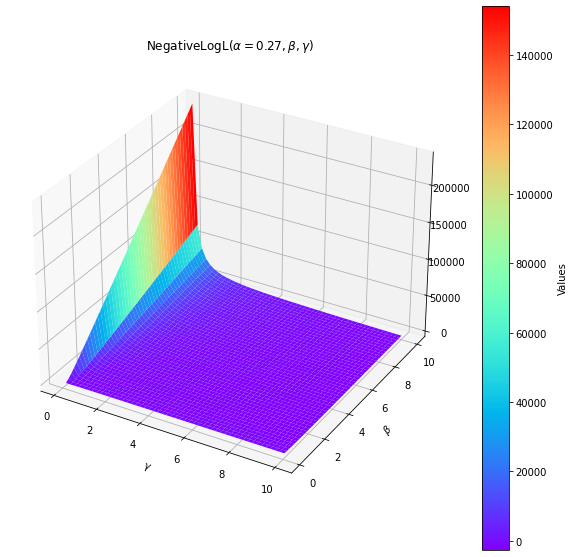

In [75]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(Y, X, Z, cmap='rainbow')  

ax.set_ylabel(r'$\beta$')
ax.set_xlabel(r'$\gamma$')
ax.set_title(r'NegativeLogL($\alpha=0.27,\beta,\gamma$)')
fig.colorbar(surface, label="Values")

## Minimization :

Let's use Scipy to minimize the function -LogL. It should not converge because of $\beta$ and $\gamma$

In [126]:
constraints = {'type': 'ineq', 'fun': constraint_function}

result = minimize (NegativeLogL, [0.37,150,500], method='Nelder-Mead', bounds = [(0, None), (0, None), (0, None)], args=(False), constraints=constraints)
temp = result.x
print(temp)


C:\Users\lalou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\_minimize.py:562: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


alpha = 0.37 | beta = 150.0 | gamma = 500.0
VALUE = -6196.834645118128
 
alpha = 0.3885 | beta = 150.0 | gamma = 500.0
VALUE = -6174.72897419964
 
alpha = 0.37 | beta = 157.5 | gamma = 500.0
VALUE = -6205.28222474658
 
alpha = 0.37 | beta = 150.0 | gamma = 525.0
VALUE = -6232.991787975368
 
alpha = 0.35149999999999987 | beta = 155.0 | gamma = 516.6666666666666
VALUE = -6246.182214563922
 
alpha = 0.33299999999999985 | beta = 157.5 | gamma = 525.0
VALUE = -6275.1820509132785
 
alpha = 0.34533333333333327 | beta = 160.0 | gamma = 533.3333333333333
VALUE = -6281.4904203130955
 
alpha = 0.33299999999999996 | beta = 165.0 | gamma = 550.0
VALUE = -6319.446512359232
 
alpha = 0.32066666666666654 | beta = 157.5 | gamma = 566.6666666666667
VALUE = -6337.52064115288
 
alpha = 0.2959999999999998 | beta = 157.5 | gamma = 600.0
VALUE = -6382.414183382326
 
alpha = 0.2713333333333331 | beta = 170.0 | gamma = 591.6666666666667
VALUE = -6387.085481494814
 
alpha = 0.22199999999999964 | beta = 180.0 | 

C:\Users\lalou\AppData\Local\Temp\ipykernel_17036\3626703991.py:6: RuntimeWarning: divide by zero encountered in log
  logL = np.log(alpha) + (1-alpha)*t  - (beta/gamma) ##La somme est vide pour n=0
C:\Users\lalou\AppData\Local\Temp\ipykernel_17036\3626703991.py:11: RuntimeWarning: divide by zero encountered in log
  logL = logL + np.log(alpha + beta*inner_sum) - (beta/gamma)* (1 - np.exp(-gamma*(t-T_list[n])))


alpha = 0.0 | beta = 3843560.6687412434 | gamma = 40565713.74796175
VALUE = inf
 
alpha = 0.44037981135330834 | beta = 3092736.170945829 | gamma = 32643382.932601165
VALUE = -16079.042524322778
 
alpha = 0.4206431705587279 | beta = 5752607.291538489 | gamma = 60716623.451135024
VALUE = -16703.93221197403
 
alpha = 0.5009733728925212 | beta = 7730339.288453534 | gamma = 81590749.70289
VALUE = -16830.610552461174
 
alpha = 0.28064183278936944 | beta = 7548749.829972863 | gamma = 79673189.31301817
VALUE = -17074.823489430426
 
alpha = 0.2007728435074 | beta = 9776756.65948638 | gamma = 103188092.50322667
VALUE = -17220.89467926627
 
alpha = 0.2758164662274025 | beta = 11066564.09895842 | gamma = 116797473.5133944
VALUE = -17437.878796962224
 
alpha = 0.2400085772650412 | beta = 14772018.24595227 | gamma = 155902862.14977878
VALUE = -17685.60396119088
 
alpha = 0.3947096799406046 | beta = 16943175.554641 | gamma = 178823723.81235027
VALUE = -17771.995755894397
 
alpha = 0.47550109532622176

As we can see above, $-LogL$  is at its minimum when $\beta$ and $\gamma$ tend indeed to $+\infty$. This result was expected according to the different plots we made.

The question we can wonder is whether $-LogL$ is bounded or not. Actually after studying the list of $T_n$, we can see that there are consecutive $T_{n-1}$ and $T_n$ that are equals. By using this information we can deduce the following proof that -LogL is not bounded.

## Proof that we can choose $\beta$ and $\gamma$ such that $-LogL$ tends to $-\infty$ :

We know that: $log(L(N,t)) = \sum_{T_n\leq t} log\left(\alpha + \beta \sum_{j=1}^{n-1} e^{- \gamma(T_n-T_j) } \right) + (1-\alpha)t - \frac{\beta}{\gamma}\sum_{T_n\leq t} \left( 1- e^{-\gamma (t-T_n)}\right)$

Take for example $\beta = \gamma -1$ so that with have the constraint $\beta<\gamma$

Choose $\gamma$ numerically high enough such that 

If $T_n\not= T_j:   e^{-\gamma(T_n-T_j)} = 0.0$ (numerically)

If $T_n= T_j : e^{-\gamma(T_n-T_j)} = 1$

In [8]:
print("Time List =", l[2:10])

Time List = [60 65 69 69 74 85 86 88]


As we can see there exists some attacks that arrive at the same time. This means that there exists $n$ such that $T_n-T_{n-1} = 0$

In the end, when $\gamma$ is high enough, $log(L(N,t))$ is numerically equal too:

$log(L(N,t)) = \sum_{T_n\leq t} log\left(\alpha + (\gamma-1) \sum_{T_j=T_n} 1 \right) + (1-\alpha)t - \frac{\gamma-1}{\gamma}\sum_{T_n < t} \left( 1- e^{-\gamma (t-T_n)}\right)$

$log(L(N,t)) = \sum_{T_n\leq t} log\left(\alpha + (\gamma-1) \times Card\{j | j<n, T_j = T_n \} \right) + (1-\alpha)t - \frac{\gamma-1}{\gamma}\sum_{T_n\leq t} \left( 1- e^{-\gamma (t-T_n)}\right)$

And we have $\frac{\gamma-1}{\gamma}\sum_{T_n\leq t} \left( 1- e^{-\gamma (t-T_n)}\right) \rightarrow Card(\{T_n | T_n < t\})$ as $\gamma \rightarrow +\infty$ which is finite

$(1-\alpha)t$ is also finite and independent of $\gamma$

Whereas $\sum_{T_n\leq t} log\left(\alpha + (\gamma-1) \times Card\{j | j<n, T_j = T_n \} \right) \rightarrow +\infty$ as $\gamma \rightarrow +\infty$

This means that by taking $\gamma = \beta+1 \rightarrow +\infty$, we have $-LogL(\alpha,\beta,\gamma) \rightarrow -\infty$ 

$\square$

### What are the consequences for the intensity ?

We have seen that we can't minimize $-LogL(\alpha,\beta,\gamma)$ with finite values. 

Looking at the expression of $\dot{y}(N,t)$

$\dot{y}(N,t) = \alpha + \beta \int_0^{t^-} e^{-\gamma(t-s)}dN(s) = \alpha + \beta \sum_{T_n<t} e^{-\gamma(t-T_n)}$

Since $\beta < \gamma$ we have $0 \leq \beta \sum_{T_n<t} e^{-\gamma(t-T_n)} \leq  \sum_{T_n<t} \gamma e^{-\gamma(t-T_n)} \rightarrow 0$ as $\gamma \rightarrow +\infty$

Hence, $\beta \sum_{T_n<t} e^{-\gamma(t-T_n)} \rightarrow 0$ as $\gamma \rightarrow +\infty$

This means that the intensity that maximizes the log-likelihood is $\dot{y}(N,t) = \alpha$ 

Which corresponds to the Poisson Process of intensity $\alpha = 0.208$

### Suppose $y(N,t) = \alpha t$ with $\alpha=0.208$

The theory says that $(y(N,T_q(N), n\geq1)$ must follow a law of a Poisson Process of intensity 1 

2.2718949273280864


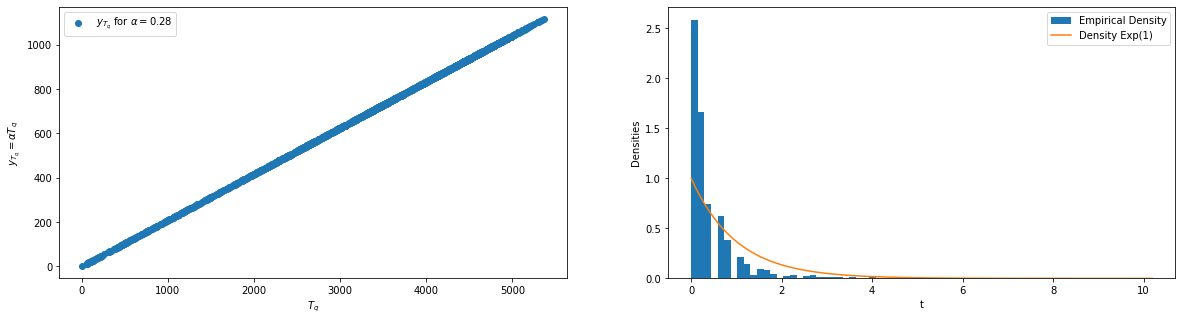

In [55]:
def y_poisson(t, alpha):
    return(alpha*t)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

yTq_poisson = [y_poisson(t,0.208) for  t in T_list]

axes[0].scatter(T_list,yTq_poisson, label=r"$y_{T_q}$ for $\alpha=0.28$")
axes[0].set_xlabel(r"$T_q$")
axes[0].set_ylabel(r"$y_{T_q} = \alpha T_q$")
axes[0].legend()

Chi_diff = []
for i in range(1, len(yTq_poisson)):
    Chi_diff.append(yTq_poisson[i] - yTq_poisson[i-1])
average = np.mean(Chi_diff)
print(1/average)

axes[1].hist(Chi_diff, bins=70, density=True, alpha=1, label='Empirical Density')

x = np.linspace(0, max(Chi_diff), 100)
theta = 1/average
y = np.exp(-x)

axes[1].plot(x, y, label='Density Exp(1)')
axes[1].set_ylabel("Densities")
axes[1].set_xlabel("t")
axes[1].legend()


$(y(N,T_q(N), n\geq1)$

We choose to do the Kolmogorov-Smirnov test in order to know if indeed $(y(N,T_q(N), n\geq1)$ is a Poisson Process of intensity 1.

In [58]:
from scipy.stats import kstest

D, p_value = kstest(Chi_diff, "expon")

print("Kolmogorov-Smirnov Test:")
print("D statistic:", D)
print("p-value:", p_value)

Kolmogorov-Smirnov Test:
D statistic: 0.43132991304533613
p-value: 0.0


$D = max\mid f_{exp} - f_{ref} \mid$ is the maximum of the difference of the two densities. Finding 0.43 is huge since $1 \cdot e^{-1\cdot t}$ is between $1$ and $0$.

As we can see the $p_{value}$ is $0$. This means that we have to reject the hypothesis

$(y(N,T_q(N), n\geq1)$ doesn't have the law of a Poisson Process of intensity 1.

Since we can't really minimize our function, our project is a bit stuck. To continue, we can try to force the paramters to be finite by using Data Science methods.

### What can we try next ?

It is possible to try to look for parameters $\alpha, \beta, \gamma$ while controlling them. We can for example add some malus when the parameters are too high. To do so we can take inspiration from Data Science Ridge/Lasso technique.

Lasso : $log(L(N,t)) = \sum_{T_n\leq t} log\left(\alpha + \beta \sum_{j=1}^{n-1} e^{- \gamma(T_n-T_j) } \right) + (1-\alpha)t - \frac{\beta}{\gamma}\sum_{T_n\leq t} \left( 1- e^{-\gamma (t-T_n)}\right) - \mid\mid (\alpha,\beta,\gamma)\mid\mid_1$

Ridge : $log(L(N,t)) = \sum_{T_n\leq t} log\left(\alpha + \beta \sum_{j=1}^{n-1} e^{- \gamma(T_n-T_j) } \right) + (1-\alpha)t - \frac{\beta}{\gamma}\sum_{T_n\leq t} \left( 1- e^{-\gamma (t-T_n)}\right) - \mid\mid (\alpha,\beta,\gamma)\mid\mid_2$

- ## Lasso Parameters Control for Minimization 

In [90]:
def NegativeLogLLasso(parameters, Dontprint=True):

    alpha, beta, gamma = parameters
    
    t=max(l)
    logL =  np.log(alpha) + (1-alpha)*t  - (beta/gamma) ##La somme est vide pour n=0
    logL = logL - (alpha + beta + gamma) # Lasso Control Norm1

    for n in range(1, len(T_list)): 


        inner_sum = np.sum(np.exp(-gamma * np.array(T_diff[n])))
        logL = logL + np.log(alpha + beta*inner_sum) - (beta/gamma)* (1 - np.exp(-gamma*(t-T_list[n])))


    if Dontprint == False :
        print("alpha = " + str(alpha) + " | beta = " + str(beta) + " | gamma = "+ str(gamma))
        print("VALUE = " + str(-logL))
        print(" ")

    return (-logL)

In [91]:
constraints = {'type': 'ineq', 'fun': constraint_function}

result = minimize (NegativeLogLLasso, [0.27,150,500], method='Nelder-Mead', bounds = [(0, None), (0, None), (0, None)], args=(False), constraints=constraints)
temp = result.x
print(temp)


C:\Users\lalou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\_minimize.py:562: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


alpha = 0.27 | beta = 150.0 | gamma = 500.0
VALUE = -5584.9722648505785
 
alpha = 0.28350000000000003 | beta = 150.0 | gamma = 500.0
VALUE = -5589.649170384607
 
alpha = 0.27 | beta = 157.5 | gamma = 500.0
VALUE = -5585.942632948463
 
alpha = 0.27 | beta = 150.0 | gamma = 525.0
VALUE = -5596.129407707962
 
alpha = 0.279 | beta = 155.0 | gamma = 516.6666666666666
VALUE = -5598.044429571822
 
alpha = 0.2835000000000001 | beta = 157.5 | gamma = 525.0
VALUE = -5603.581460527556
 
alpha = 0.28800000000000014 | beta = 147.5 | gamma = 533.3333333333333
VALUE = -5602.888104704538
 
alpha = 0.27750000000000014 | beta = 153.33333333333331 | gamma = 555.5555555555554
VALUE = -5610.805791110473
 
alpha = 0.2745000000000002 | beta = 155.0 | gamma = 583.333333333333
VALUE = -5616.601159540583
 
alpha = 0.29400000000000026 | beta = 156.66666666666669 | gamma = 569.4444444444441
VALUE = -5619.028081305616
 
alpha = 0.3060000000000004 | beta = 160.0 | gamma = 591.6666666666661
VALUE = -5624.24489452695

In [97]:
parameters_lasso = result.x
print(parameters_lasso)

[2.94498943e-01 2.14756216e+02 7.37257199e+02]


With our "homemade Lasso Inspiration Parameters Control", we find 

$\alpha = 0.29449895167556306$

$\beta = 214.75622979153047$

$\gamma = 737.2572251191698$

C:\Users\lalou\AppData\Local\Temp\ipykernel_30804\1216619848.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(y_point_lasso, 0, t, args=(alpha, beta, gamma))


1.6046038765690773


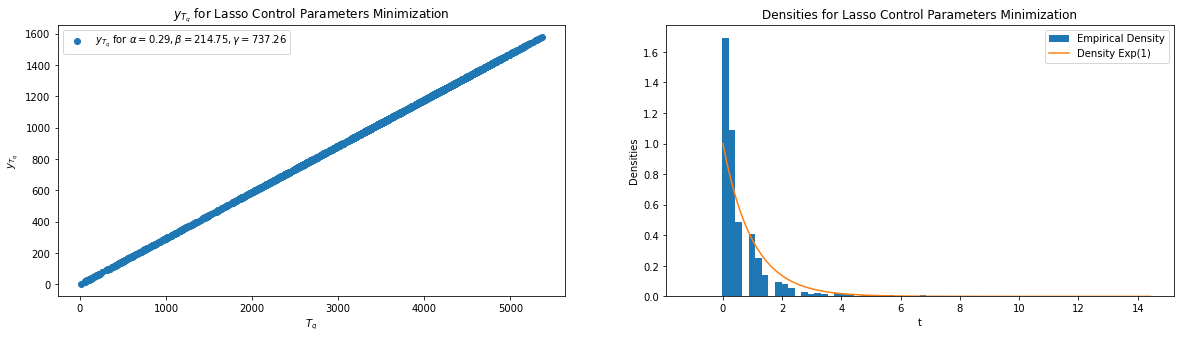

In [110]:
from scipy.integrate import quad

def y_point_lasso(t, alpha, beta, gamma):
    Tn_list = np.array(T_list)[np.array(T_list) < t]

    y_point = alpha + beta* np.sum(np.exp(-gamma*(t-Tn_list)))

    return(y_point)

def y_lasso(t,alpha, beta, gamma):
    result, error = quad(y_point_lasso, 0, t, args=(alpha, beta, gamma))
    return(result, error)

alpha, beta, gamma = result.x

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

yTq_lasso = [y_lasso(t, alpha, beta, gamma)[0] for  t in T_list]

axes[0].scatter(T_list , yTq_lasso, label=r"$y_{T_q}$ for $\alpha=0.29, \beta=214.75, \gamma=737.26$")
axes[0].set_title(r"$y_{T_q}$ for Lasso Control Parameters Minimization")
axes[0].set_xlabel(r"$T_q$")
axes[0].set_ylabel(r"$y_{T_q}$")
axes[0].legend()

Chi_diff = []
for i in range(1, len(yTq_lasso)):
    Chi_diff.append(yTq_lasso[i] - yTq_lasso[i-1])
average = np.mean(Chi_diff)
print(r"Empirical average inter arrival time value  $Y_{T_q}$ = ", 1/average)

axes[1].hist(Chi_diff, bins=70, density=True, alpha=1, label='Empirical Density')

x = np.linspace(0, max(Chi_diff), 100)
theta = 1/average
y = np.exp(-x)


axes[1].plot(x, y, label='Density Exp(1)')
axes[1].set_title("Densities for Lasso Control Parameters Minimization")
axes[1].set_ylabel("Densities")
axes[1].set_xlabel("t")
axes[1].legend()


In [106]:
from scipy.stats import kstest

D, p_value = kstest(Chi_diff, "expon")

print("Kolmogorov-Smirnov Test:")
print("D statistic:", D)
print("p-value:", p_value)

Kolmogorov-Smirnov Test:
D statistic: 0.3769261161596207
p-value: 0.0


Our parameter $D$ seems to be a bit better than before, but it is still too high...

We find again $p_{value}=0$ this means that we can again reject the hypothesis.

- ## Ridge Parameters Control for Minimization 

In [112]:
def NegativeLogLRidge(parameters, Dontprint=True):

    alpha, beta, gamma = parameters
    
    t=max(l)
    logL =  np.log(alpha) + (1-alpha)*t  - (beta/gamma) ##La somme est vide pour n=0
    logL = logL - np.sqrt(alpha**2 + beta**2 + gamma**2) ### Ridge Control Norm2 

    for n in range(1, len(T_list)): 


        inner_sum = np.sum(np.exp(-gamma * np.array(T_diff[n])))
        logL = logL + np.log(alpha + beta*inner_sum) - (beta/gamma)* (1 - np.exp(-gamma*(t-T_list[n])))

   


    if Dontprint == False :
        print("alpha = " + str(alpha) + " | beta = " + str(beta) + " | gamma = "+ str(gamma))
        print("VALUE = " + str(-logL))
        print(" ")

    return (-logL)

In [113]:
constraints = {'type': 'ineq', 'fun': constraint_function}

result = minimize (NegativeLogLRidge, [0.27,150,500], method='Nelder-Mead', bounds = [(0, None), (0, None), (0, None)], args=(False), constraints=constraints)
temp = result.x
print(temp)


C:\Users\lalou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\_minimize.py:562: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


alpha = 0.27 | beta = 150.0 | gamma = 500.0
VALUE = -5713.226869579509
 
alpha = 0.28350000000000003 | beta = 150.0 | gamma = 500.0
VALUE = -5717.917267956432
 
alpha = 0.27 | beta = 157.5 | gamma = 500.0
VALUE = -5719.4929052578755
 
alpha = 0.27 | beta = 150.0 | gamma = 525.0
VALUE = -5725.3910992546635
 
alpha = 0.279 | beta = 155.0 | gamma = 516.6666666666666
VALUE = -5730.574187791726
 
alpha = 0.2835000000000001 | beta = 157.5 | gamma = 525.0
VALUE = -5738.248795492955
 
alpha = 0.2655 | beta = 160.0 | gamma = 533.3333333333333
VALUE = -5737.429464568861
 
alpha = 0.27600000000000013 | beta = 154.16666666666669 | gamma = 555.5555555555554
VALUE = -5744.265106994553
 
alpha = 0.27900000000000014 | beta = 152.5 | gamma = 583.333333333333
VALUE = -5749.201435817464
 
alpha = 0.28200000000000014 | beta = 163.33333333333331 | gamma = 569.4444444444441
VALUE = -5761.568950740657
 
alpha = 0.28800000000000026 | beta = 170.0 | gamma = 591.6666666666661
VALUE = -5776.278987449075
 
alpha 

With our "homemade Ridge Inspiration Parameters Control", we find 

$\alpha = 0.0.2944995278412297$

$\beta = 304.7154022806565$

$\gamma = 902.2376769185241$

Empirical average inter arrival time value  $Y_{T_q}$ =  1.6046006876418655


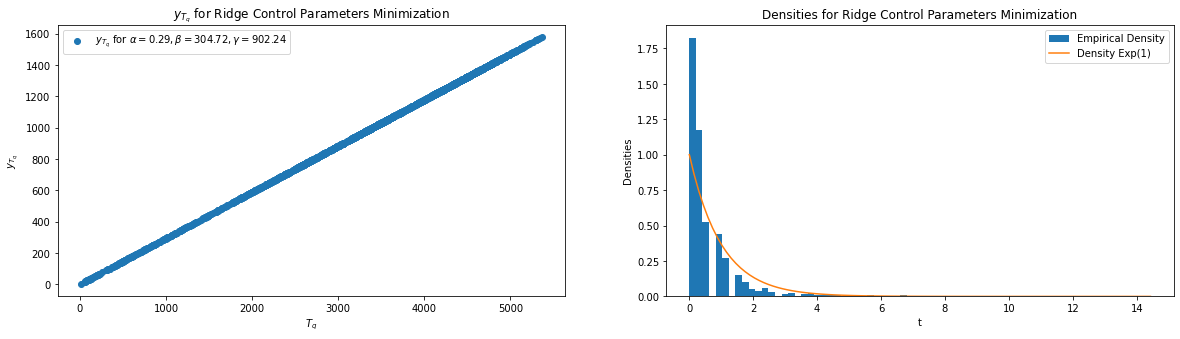

In [122]:
from scipy.integrate import quad

def y_point_Ridge(t, alpha, beta, gamma):
    Tn_list = np.array(T_list)[np.array(T_list) < t]

    y_point = alpha + beta* np.sum(np.exp(-gamma*(t-Tn_list)))

    return(y_point)

def y_Ridge(t,alpha, beta, gamma):
    result, error = quad(y_point_Ridge, 0, t, args=(alpha, beta, gamma))
    return(result, error)

alpha, beta, gamma = result.x

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

yTq_Ridge = [y_Ridge(t, alpha, beta, gamma)[0] for  t in T_list]

axes[0].scatter(T_list , yTq_Ridge, label=r"$y_{T_q}$ for $\alpha=0.29, \beta=304.72, \gamma=902.24$")
axes[0].set_title(r"$y_{T_q}$ for Ridge Control Parameters Minimization")
axes[0].set_xlabel(r"$T_q$")
axes[0].set_ylabel(r"$y_{T_q}$")
axes[0].legend()

Chi_diff = []
for i in range(1, len(yTq_Ridge)):
    Chi_diff.append(yTq_Ridge[i] - yTq_Ridge[i-1])
average = np.mean(Chi_diff)
print(r"Empirical average inter arrival time value  $Y_{T_q}$ = ", 1/average)

axes[1].hist(Chi_diff, bins=70, density=True, alpha=1, label='Empirical Density')

x = np.linspace(0, max(Chi_diff), 100)
theta = 1/average
y = np.exp(-x)


axes[1].plot(x, y, label='Density Exp(1)')
axes[1].set_title("Densities for Ridge Control Parameters Minimization")
axes[1].set_ylabel("Densities")
axes[1].set_xlabel("t")
axes[1].legend()


In [123]:
from scipy.stats import kstest

D, p_value = kstest(Chi_diff, "expon")

print("Kolmogorov-Smirnov Test:")
print("D statistic:", D)
print("p-value:", p_value)



Kolmogorov-Smirnov Test:
D statistic: 0.3765310154089293
p-value: 0.0


Once again, our $D$ statistics is too high.

We find again $p_{value}=0$ this means that we can again reject the hypothesis.

# `Conclusion`

To conclude, we have tried to minimize the -LogL function to find the best parameters $\alpha, \beta, \gamma$ in order to describe the time arrivals of the cybersecurity attacks as a Hawkes Process

However as we have seen it is possible to find a triplet $\alpha, \beta, \gamma$ which makes $-LogL$ tends to $-\infty$. This has led us to consider a linear $PP(\alpha)$ instead of a Hawkes Process. But the Kolmogorov-Smirnov test on $(y(N,T_q(N), n\geq1)$ led us to reject the hypothesis.

We tried to bound the parameters $\alpha, \beta, \gamma$ by using some Lasso and Ridge regulations. However, once again, these two ideas led us to a deadend. For both Kolmogorov-Smirnov tests, we had a $p_{value}$ of $0$.

We have tried many different ideas but according to our results, `it seems that we can't modelize the arrival times of the cybersecurity attacks by a Hawkes Process`.

